In [119]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import imageio
import random
import idx2numpy
import tarfile

from urllib.request import urlretrieve
from scipy.io import loadmat

tf.keras.backend.set_floatx('float32')

In [ ]:
import gzip
import shutil
import tarfile

def download_file(url, path):
    print("Downloading from %s" % url)
    urlretrieve(url, path)
    
def download_and_unzip(url, path):
    print("Downloading from %s" % url)
    zip_path = path + ".zip"
    urlretrieve(url, zip_path)
    with gzip.open(zip_path, 'rb') as f_in:
        with open(path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    os.remove(zip_path)
            
def download_and_unzip_tar(url):
    zip_path = "temp.zip"
    urlretrieve(url, zip_path)
    tar = tarfile.open(zip_path, "r:gz")
    tar.extractall()
    tar.close()
    os.remove(zip_path)    

In [2]:
# MNIST 

def read_idx_file(filename):
    with open(filename, 'rb') as f:
        return idx2numpy.convert_from_file(f)
    
def load_data(images_file, labels_file):
    images = read_idx_file(images_file) / 255
    images_len = len(images)
    images = images.reshape((images_len, 28, 28, 1))
    return images, read_idx_file(labels_file)
        
def unzip(tuples):
    first = [t[0] for t in tuples]
    second = [t[1] for t in tuples]
    return np.array(first), np.array(second)

In [3]:
# MNIST files

train_images_file = "train-images.byte"
train_labels_file = "train-labels.byte"
test_images_file = "test-images.byte"
test_labels_file = "test-labels.byte"

In [ ]:
# Download mnist

download_and_unzip("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", train_images_file)
download_and_unzip("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz", train_labels_file)
download_and_unzip("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", test_images_file)
download_and_unzip("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz", test_labels_file)

In [ ]:
train_images, train_labels = load_data(train_images_file, train_labels_file)
test_images, test_labels = load_data(test_images_file, test_labels_file)

In [ ]:
# Show MNIST images

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns * rows + 1):
    img = random.choice(train_images)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.reshape(28, 28), interpolation='nearest', cmap='Greys')
plt.show()

In [ ]:
# Generate syntatic data

def generate_synt_data(max_number_length, images, labels):
    max_number_length = 5
    images_len, height, width, _ = images.shape
    synt_x, synt_y = [], []
    for _ in range(images_len):
        image = np.zeros((height, width * 5))
        length = random.randint(1, max_number_length)
        offset = random.randint(0, max_number_length - length)
        number_labels = [10] * max_number_length
        for pos in range(offset, offset + length):
            image_id = random.randint(0, images_len - 1)
            img = images[image_id]
            img = img.reshape((width, height))
            image[:, pos * width: pos * width + width] = img
            number_labels[pos] = labels[image_id]
        plt.imshow(image, cmap='Greys')
        synt_y.append(number_labels)
        synt_x.append(image.reshape((height, width * 5,  1)))
    return np.array(synt_x), np.array(synt_y)

In [ ]:
synt_train_x, synt_train_y = generate_synt_data(5, train_images, train_labels)
synt_test_x, synt_test_y = generate_synt_data(5, test_images, test_labels)

In [ ]:
fig = plt.figure(figsize=(40, 8))
rows = 4
cols = 3
for i in range(1, columns * rows + 1):
    img = random.choice(synt_train_x)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.reshape((28, 140)), interpolation='nearest', cmap='Greys')
plt.show()

In [ ]:
# Model 

from tensorflow.keras import layers, Model, Input, Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, BatchNormalization, MaxPooling2D

num_classes = 10 + 1

input_images = Input(shape=(32, 160, 1))

model = Conv2D(16, kernel_size=(2, 2), activation='relu', padding="same")(input_images)
model = MaxPooling2D(pool_size=(2, 2), padding='valid')(model)
model = Dropout(0.5)(model)

model = Conv2D(32, kernel_size=(2, 2), activation='relu', padding='valid')(model)
model = MaxPooling2D(pool_size=(2, 2), padding='valid')(model)
model = Dropout(0.5)(model)

model = Conv2D(64, kernel_size=(2, 2), activation='relu', padding='valid')(model)
model = MaxPooling2D(pool_size=(2, 2), padding='valid')(model)
model = Dropout(0.5)(model)

model = Conv2D(128, kernel_size=(2, 2), activation='relu', padding='valid')(model)
model = MaxPooling2D(pool_size=(2, 2), padding='valid')(model)
model = Dropout(0.5)(model)

model = Flatten()(model)
model = Dense(1024, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(1024, activation="relu")(model)

first_num = Dense(num_classes, activation="softmax")(model)
second_num = Dense(num_classes, activation="softmax")(model)
third_num = Dense(num_classes, activation="softmax")(model)
fourth_num = Dense(num_classes, activation="softmax")(model)
fifth_num = Dense(num_classes, activation="softmax")(model)

model = Model(inputs=input_images, outputs=[first_num, second_num, third_num, fourth_num, fifth_num])
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
synt_train_ys = [synt_train_y.T[i] for i in range(5)]
model.fit(synt_train_x, synt_train_ys, batch_size=32, epochs=8)

In [ ]:
# Download google images

download_and_unzip_tar("http://ufldl.stanford.edu/housenumbers/train.tar.gz")
download_and_unzip_tar("http://ufldl.stanford.edu/housenumbers/test.tar.gz")

In [ ]:
# Analyze sizes of images

sizes = []
for filename in os.listdir("train"):
    try:
        google_image = imageio.imread("train/" + filename)
        height, width, _ = google_image.shape
        sizes.append((height, width, filename))
    except:
        continue

ratios = [p[0] / p[1] for p in sizes]
plt.hist(ratios)
np.mean(ratios)

In [40]:
# Mean ratio is ~0.45. So let's take ideal size with this ratio.

ideal_height = 54
ideal_width = 120

In [ ]:
# Resize train and test set and save these images, in order not to repeat this process each time.

def resize(img, ideal_height, ideal_width):
    height, width, _ = google_image.shape
    rate = height / ideal_height
    target_width = int(width / rate)
    if target_width < ideal_width:
        rate = width / ideal_width
        target_height = int(height / rate)
        img = tf.image.resize(google_image, (target_height, ideal_width))# / 255
    else:
        img = tf.image.resize(google_image, (ideal_height, target_width))# / 255

    img = tf.image.random_crop(img, (ideal_height, ideal_width, 3))
    return img


for filename in os.listdir("train")[:5]:
    google_image = imageio.imread("train/" + filename)
    img = resize(google_image, ideal_height, ideal_width) / 255
    plt.imshow(img)
    plt.show()
    
def resize_image_dataset(folder)
    for filename in os.listdir(folder):
        print(filename)
        try:
            google_image = imageio.imread(folder + "/" + filename)
        except:
            continue
        img = resize(google_image, ideal_height, ideal_width)
        imageio.imsave("%s_resize/" % folder + filename, np.array(img))
        
# resize_image_dataset("train")
# resize_image_dataset("test")

In [97]:
import h5py

def read_google_images_data(filename, images_folder, max_label_length):
    with h5py.File(filename, 'r') as f:
        name = f['/digitStruct/name']
        bbox = f['/digitStruct/bbox']
        
        def get_name(f, i):
            return ''.join([chr(v[0]) for v in f[name[i][0]]])

        def get_label(f, i):
            label_attr = f[bbox[i].item()]["label"]
            if len(label_attr) > 1:
                attr = [f[label_attr[j].item()][0][0] for j in range(len(label_attr))]
            else:
                attr = [label_attr[0][0]]
            return attr

        size = len(name)
        data = []
        for i in range(size):
            image_name = get_name(f, i)
            image = imageio.imread(images_folder + "/" + image_name)
            height, width, _ = image.shape
            image = np.mean(image, axis=2).reshape((height, width, 1)) / 255
            labels = list(get_label(f, i))
            label_len = len(labels)
            if label_len > max_label_length:
                continue
            else:
                labels.extend([10] * (max_label_length - label_len))
            labels.append(label_len)
            data.append((image, labels))
        return data

In [98]:
google_train_data = read_google_images_data("train/digitStruct.mat", "train_resize", 4)
google_test_data = read_google_images_data("test/digitStruct.mat", "test_resize", 4)

# Split train by train and val

train_len = len(google_train_data)
val_len = int(train_len * 0.05)
random.shuffle(google_train_data)
google_val_data = google_train_data[:val_len]
google_train_data = google_train_data[val_len:]

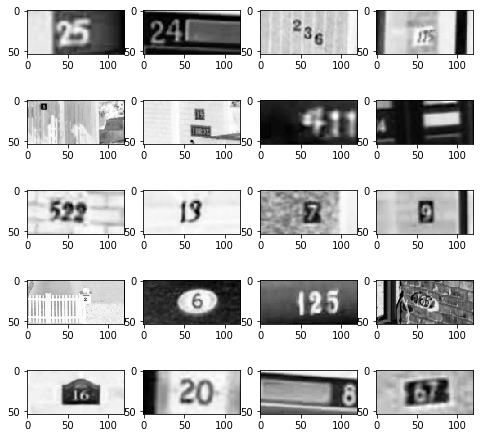

In [99]:
# Draw some google images

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns * rows + 1):
    img = random.choice(google_test_data)[0].reshape(ideal_height, ideal_width)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, interpolation='nearest', cmap='Greys')

In [113]:
# Model 

from tensorflow.keras import layers, Model, Input, Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, BatchNormalization, MaxPooling2D, AveragePooling2D

num_classes = 10 + 1
ideal_height = 54
ideal_width = 120

input_images = Input(shape=(ideal_height, ideal_width, 1))

model = Conv2D(16, kernel_size=(8, 16), activation='relu')(input_images)
model = MaxPooling2D(pool_size=(2, 2))(model)

model = Conv2D(32, kernel_size=(4, 8), activation='relu')(model)
model = MaxPooling2D(pool_size=(1, 2))(model)

model = Conv2D(64, kernel_size=(2, 4), activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 1))(model)

model = Conv2D(128, kernel_size=(1, 2), activation='relu')(model)
model = AveragePooling2D(pool_size=(1, 2))(model)

model = Conv2D(256, kernel_size=(1, 2), activation='relu')(model)
model = AveragePooling2D(pool_size=(2, 1))(model)

model = Conv2D(256, kernel_size=(1, 2), activation='relu')(model)
model = MaxPooling2D(pool_size=(1, 2))(model)

model = Conv2D(256, kernel_size=(2, 2), activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

model = Flatten()(model)
model = Dense(2048, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(2048, activation="relu")(model)
model = Dropout(0.5)(model)

first_num = Dense(num_classes, activation="softmax")(model)
second_num = Dense(num_classes, activation="softmax")(model)
third_num = Dense(num_classes, activation="softmax")(model)
fourth_num = Dense(num_classes, activation="softmax")(model)
number_length = Dense(6, activation="softmax")(model)

model = Model(inputs=input_images, outputs=[first_num, second_num, third_num, fourth_num, number_length])
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 54, 120, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 47, 105, 16)  2064        input_17[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_60 (MaxPooling2D) (None, 23, 52, 16)   0           conv2d_81[0][0]                  
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 20, 45, 32)   16416       max_pooling2d_60[0][0]           
___________________________________________________________________________________________

In [114]:
# Preprate data for fitting

google_train_x, google_train_y = unzip(google_train_data)
google_train_y = [google_train_y.T[i] for i in range(5)]

google_val_x, google_val_y = unzip(google_val_data)
google_val_y = [google_val_y.T[i] for i in range(5)]

google_test_x, google_test_y = unzip(google_test_data)
google_test_y = [google_test_y.T[i] for i in range(5)]

In [115]:
model.fit(google_train_x, google_train_y, batch_size=32, epochs=10, validation_data=(google_val_x, google_val_y))

Train on 31723 samples, validate on 1669 samples
Epoch 1/10
31723/31723 [==============================] - 323s 10ms/sample - loss: 6.7089 - dense_96_loss: 2.0352 - dense_97_loss: 2.1961 - dense_98_loss: 1.1543 - dense_99_loss: 0.2500 - dense_100_loss: 1.0730 - dense_96_accuracy: 0.2707 - dense_97_accuracy: 0.2531 - dense_98_accuracy: 0.7347 - dense_99_accuracy: 0.9622 - dense_100_accuracy: 0.5480 - val_loss: 6.4810 - val_dense_96_loss: 2.0079 - val_dense_97_loss: 2.1631 - val_dense_98_loss: 1.1272 - val_dense_99_loss: 0.1823 - val_dense_100_loss: 0.9745 - val_dense_96_accuracy: 0.2792 - val_dense_97_accuracy: 0.2558 - val_dense_98_accuracy: 0.7334 - val_dense_99_accuracy: 0.9724 - val_dense_100_accuracy: 0.5746
Epoch 2/10
31723/31723 [==============================] - 320s 10ms/sample - loss: 6.4970 - dense_96_loss: 2.0131 - dense_97_loss: 2.1596 - dense_98_loss: 1.1130 - dense_99_loss: 0.2345 - dense_100_loss: 0.9773 - dense_96_accuracy: 0.2719 - dense_97_accuracy: 0.2544 - dense_98_

In [127]:
input_images = Input(shape=(ideal_height, ideal_width, 1))
p = 0.5
n_class = 11
n_len = 6

x = BatchNormalization()(input_images)
x = Conv2D(48, 5, activation='relu', padding='same', strides=(1, 1))(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Dropout(p/4)(x)
    
x = BatchNormalization()(x)
x = Conv2D(64, 5, activation='relu', padding='same', strides=(1, 1))(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
x = Dropout(p/4)(x)

x = BatchNormalization()(x)
x = Conv2D(128, 5, activation='relu', padding='same', strides=(1, 1))(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Dropout(p/2)(x)

x = BatchNormalization()(x)
x = Conv2D(160, 5, activation='relu', padding='same', strides=(1, 1))(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
x = Dropout(p/2)(x)

x = BatchNormalization()(x)
x = Conv2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Dropout(p)(x)

x = BatchNormalization()(x)
x = Conv2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
x = Dropout(p)(x)
    
x = BatchNormalization()(x)
x = Conv2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Dropout(p)(x)

x = BatchNormalization()(x)
x = Conv2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
x = Dropout(p)(x)
    
x = Flatten()(x)
x = Dense(3072, activation='relu')(x)
x = Dense(3072, activation='relu')(x)

c1 = Dense(n_class, activation='softmax')(x)
c2 = Dense(n_class, activation='softmax')(x)
c3 = Dense(n_class, activation='softmax')(x)
c4 = Dense(n_class, activation='softmax')(x)
l = Dense(n_len, activation='softmax')(x)
    
output = [c1, c2, c3, c4, l]
    
model = Model(inputs=input_images, outputs=output)
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 54, 120, 1)] 0                                            
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 54, 120, 1)   4           input_26[0][0]                   
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 54, 120, 48)  1248        batch_normalization_36[0][0]     
__________________________________________________________________________________________________
max_pooling2d_98 (MaxPooling2D) (None, 27, 60, 48)   0           conv2d_121[0][0]                 
___________________________________________________________________________________________

In [ ]:
model.fit(
    google_train_x, google_train_y,
    epochs=5,
    batch_size=64,
    validation_data=(google_val_x, google_val_y),
    verbose=1)

Train on 31723 samples, validate on 1669 samples
Epoch 1/5
28992/31723 [==========================>...] - ETA: 6:29 - loss: 6.0811 - dense_125_loss: 1.9455 - dense_126_loss: 2.1021 - dense_127_loss: 1.0244 - dense_128_loss: 0.2166 - dense_129_loss: 0.7925 - dense_125_sparse_categorical_accuracy: 0.3144 - dense_126_sparse_categorical_accuracy: 0.2570 - dense_127_sparse_categorical_accuracy: 0.7361 - dense_128_sparse_categorical_accuracy: 0.9633 - dense_129_sparse_categorical_accuracy: 0.6703

In [116]:
total = len(google_test_x)
accurate = 0
predictions = model.predict(google_test_x)
for i in range(total):
    prediction = [np.argmax(predictions[j][i]) for j in range(5)]
    expected = [google_test_y[j][i] for j in range(5)]

    expected_number = "".join([str(int(e)) for e in expected if e != 10])
    predicted_number = "".join([str(int(p)) for p in prediction if p != 10])
    print("%s == %s" % (expected_number, predicted_number))
    if expected_number == predicted_number:
        accurate += 1

print(accurate / total)

51 == 51
213 == 13
61 == 12
11 == 91
91 == 12
11 == 112
1833 == 123
652 == 62
1443 == 113
162 == 13
342 == 342
22 == 22
132 == 41
252 == 192
41 == 112
142 == 142
282 == 12
382 == 332
62 == 12
1513 == 1113
1293 == 51
162 == 163
91 == 12
262 == 22
11 == 11
22 == 352
692 == 32
152 == 123
192 == 13
812 == 32
512 == 52
51 == 12
292 == 23
242 == 21
12 == 12
692 == 672
322 == 13
352 == 123
11 == 12
1463 == 123
282 == 222
31 == 52
142 == 32
17124 == 1773
172 == 172
12 == 182
142 == 12
462 == 182
442 == 442
282 == 722
172 == 13
742 == 52
81 == 392
232 == 222
21 == 22
232 == 22
1863 == 1653
3763 == 1163
32 == 13
722 == 13
742 == 332
2883 == 123
172 == 13
192 == 122
342 == 13
21 == 21
962 == 13
263 == 12
81 == 81
22 == 12
12 == 41
322 == 41
242 == 91
672 == 13
212 == 212
352 == 12
312 == 31
592 == 432
182 == 13
122 == 12
61 == 61
462 == 142
492 == 492
362 == 362
113 == 13
252 == 123
272 == 52
522 == 12
21 == 222
142 == 112
21 == 31
91 == 12
672 == 972
123 == 13
142 == 142
832 == 852
21 == 12
162 

122 == 42
642 == 51
1413 == 142
11 == 11
262 == 32
682 == 632
472 == 472
622 == 52
7123 == 113
512 == 22
12 == 12
12 == 22
2853 == 1953
62 == 662
52 == 12
91 == 51
232 == 242
182 == 362
51 == 23
392 == 52
152 == 152
732 == 12
152 == 143
962 == 852
252 == 252
732 == 253
142 == 142
12 == 23
152 == 152
132 == 42
52 == 622
122 == 22
62 == 13
452 == 12
142 == 12
142 == 122
692 == 13
372 == 12
422 == 442
51 == 42
242 == 41
42 == 42
2673 == 13
192 == 192
12 == 192
253 == 13
522 == 13
932 == 432
692 == 123
41 == 23
392 == 22
21 == 71
642 == 12
1143 == 1143
143 == 13
322 == 123
672 == 22
61 == 61
12 == 23
21 == 21
152 == 152
772 == 52
122 == 122
62 == 12
152 == 152
11 == 12
1263 == 123
21 == 31
142 == 12
3973 == 153
182 == 162
1643 == 172
112 == 13
162 == 12
382 == 253
2133 == 31
242 == 222
1923 == 12
152 == 174
192 == 192
172 == 172
1133 == 1293
342 == 13
352 == 12
252 == 61
152 == 152
11 == 112
12 == 732
372 == 12
1483 == 163
1743 == 172
13 == 123
552 == 222
812 == 233
332 == 532
81 == 61
252

1633 == 12
62 == 182
822 == 13
22 == 122
542 == 32
222 == 81
81 == 51
212 == 232
722 == 232
51 == 51
872 == 572
742 == 442
372 == 153
352 == 352
162 == 152
12 == 172
342 == 242
492 == 42
172 == 12
472 == 41
982 == 352
292 == 21
982 == 61
11 == 11
1523 == 52
192 == 13
432 == 392
842 == 242
3693 == 52
482 == 482
692 == 42
21 == 12
232 == 12
12 == 12
1573 == 1513
492 == 12
61 == 51
11 == 11
582 == 582
1973 == 972
2353 == 4553
22 == 22
122 == 122
62 == 192
352 == 532
122 == 122
12 == 173
342 == 52
7223 == 772
282 == 12
562 == 32
112 == 142
492 == 11
362 == 363
71 == 61
1773 == 472
2163 == 233
31 == 31
3273 == 13
232 == 12
1973 == 113
41 == 441
522 == 522
422 == 12
1573 == 123
12 == 12
532 == 632
122 == 122
832 == 123
252 == 12
252 == 2773
272 == 232
172 == 12
12 == 123
332 == 352
462 == 482
31 == 132
322 == 522
16914 == 23
892 == 692
712 == 232
362 == 362
342 == 342
153 == 13
362 == 13
1123 == 12
3493 == 193
142 == 32
1713 == 12
222 == 222
1623 == 163
7613 == 162
612 == 812
3693 == 173
61 

21 == 21
122 == 21
21 == 11
332 == 12
142 == 22
112 == 112
473 == 12
692 == 22
142 == 142
682 == 12
1964 == 123
152 == 152
113 == 23
42 == 41
222 == 223
522 == 61
172 == 13
232 == 233
252 == 222
112 == 112
382 == 12
972 == 972
182 == 12
132 == 132
212 == 212
512 == 52
22 == 282
21 == 21
162 == 123
572 == 223
832 == 32
752 == 51
482 == 452
32 == 32
81 == 61
91 == 22
6293 == 122
162 == 12
532 == 52
282 == 23
382 == 12
352 == 13
182 == 22
722 == 722
732 == 52
122 == 123
132 == 23
41 == 13
12 == 13
392 == 223
332 == 352
1273 == 12
21 == 22
682 == 41
2913 == 792
572 == 122
61 == 61
91 == 13
22 == 52
12 == 112
532 == 51
472 == 472
1343 == 13
222 == 12
91 == 61
22 == 52
522 == 13
372 == 372
742 == 742
62 == 52
192 == 51
472 == 13
272 == 21
41 == 23
272 == 12
192 == 182
232 == 13
31 == 112
61 == 12
552 == 23
12 == 12
21 == 223
253 == 22
152 == 123
81 == 582
912 == 223
173 == 13
52 == 62
81 == 192
842 == 342
1253 == 1223
692 == 61
492 == 12
423 == 13
1194 == 22
41 == 452
12 == 12
8753 == 12
32 

1183 == 162
252 == 32
9763 == 12
232 == 222
62 == 12
312 == 123
432 == 133
222 == 752
342 == 442
82 == 142
262 == 122
532 == 13
882 == 22
1253 == 13
61 == 61
132 == 132
172 == 772
172 == 172
332 == 332
412 == 472
452 == 153
132 == 123
132 == 163
21 == 21
452 == 52
122 == 133
742 == 742
143 == 12
442 == 232
4153 == 152
132 == 223
712 == 213
122 == 122
31 == 31
142 == 13
132 == 182
213 == 23
352 == 152
132 == 152
782 == 12
332 == 123
312 == 12
32 == 12
12 == 42
192 == 123
232 == 192
632 == 662
41 == 41
622 == 622
11324 == 123
992 == 123
272 == 272
42 == 442
72 == 12
972 == 472
51 == 51
192 == 192
5793 == 572
962 == 12
972 == 23
152 == 692
232 == 732
392 == 32
222 == 123
193 == 13
372 == 12
73 == 112
472 == 42
182 == 12
182 == 182
112 == 112
262 == 762
31 == 522
52 == 52
252 == 223
312 == 412
572 == 72
1223 == 123
222 == 12
32 == 32
242 == 242
132 == 62
172 == 732
662 == 652
282 == 212
752 == 223
632 == 132
172 == 22
782 == 272
912 == 222
41 == 41
182 == 13
1563 == 41
12 == 182
332 == 12


152 == 152
192 == 13
81 == 22
173 == 12
632 == 153
122 == 12
662 == 13
172 == 172
352 == 352
21 == 31
81 == 91
222 == 222
52 == 52
272 == 173
71 == 71
162 == 13
172 == 172
112 == 23
812 == 312
21 == 22
492 == 123
122 == 13
812 == 242
12 == 12
61 == 61
322 == 522
1423 == 1443
752 == 123
41 == 41
81 == 91
222 == 23
52 == 13
212 == 12
182 == 23
242 == 222
762 == 222
282 == 242
342 == 342
862 == 23
1973 == 123
942 == 232
3163 == 23
222 == 22
1273 == 13
282 == 282
62 == 22
442 == 22
1433 == 1333
242 == 223
382 == 12
1423 == 123
432 == 12
132 == 152
2893 == 242
232 == 222
762 == 13
762 == 23
492 == 123
2223 == 123
242 == 242
172 == 13
162 == 162
272 == 52
732 == 12
212 == 212
1763 == 173
542 == 123
362 == 52
132 == 362
4573 == 12
91 == 52
253 == 322
322 == 13
112 == 91
632 == 532
1913 == 232
212 == 51
52 == 52
32 == 313
412 == 442
142 == 143
122 == 122
22 == 13
332 == 12
372 == 332
3733 == 234
742 == 212
11 == 11
71 == 12
572 == 572
71 == 223
31 == 22
21 == 71
112 == 12
892 == 42
752 == 352


772 == 123
81 == 12
1213 == 13
1243 == 13
11 == 23
632 == 52
292 == 52
52 == 32
42 == 123
12 == 143
452 == 12
112 == 12
152 == 152
732 == 132
622 == 672
152 == 152
452 == 272
542 == 243
51 == 52
32 == 52
1453 == 123
232 == 13
262 == 232
3113 == 24
1743 == 1242
1513 == 13
21 == 22
122 == 122
422 == 22
112 == 12
352 == 13
1173 == 123
272 == 13
132 == 173
482 == 122
512 == 13
222 == 12
1223 == 173
562 == 13
51 == 31
272 == 592
842 == 232
52 == 42
282 == 273
162 == 162
872 == 422
862 == 862
992 == 332
183 == 12
2483 == 123
312 == 62
71 == 71
232 == 12
32 == 272
262 == 12
422 == 422
562 == 332
51 == 362
132 == 12
262 == 123
462 == 462
372 == 372
142 == 142
262 == 41
21 == 22
682 == 852
133 == 1243
12 == 113
282 == 222
292 == 72
542 == 522
91 == 11
92 == 223
242 == 72
852 == 73
962 == 13
31 == 51
232 == 23
1513 == 172
682 == 643
182 == 152
152 == 13
922 == 13
582 == 22
61 == 81
21 == 1243
822 == 622
252 == 72
1583 == 1553
242 == 242
152 == 12
91 == 91
352 == 22
922 == 232
562 == 12
122 == 12

942 == 123
1133 == 1133
442 == 423
5413 == 31
31 == 31
31 == 31
382 == 173
62 == 153
22 == 22
422 == 12
91 == 422
112 == 172
21794 == 2234
522 == 13
362 == 61
61 == 12
482 == 42
472 == 22
972 == 13
372 == 23
22 == 282
162 == 162
31 == 51
2243 == 13
132 == 132
41 == 41
193 == 352
672 == 632
262 == 752
71 == 71
71 == 22
872 == 23
1923 == 1223
452 == 51
32 == 223
482 == 452
752 == 752
172 == 172
22 == 12
142 == 13
61 == 12
112 == 33
1173 == 1773
172 == 273
742 == 62
41 == 672
2313 == 13
112 == 273
252 == 13
41 == 12
32 == 32
1553 == 1653
62 == 52
932 == 932
192 == 182
282 == 42
1843 == 1233
232 == 232
51 == 123
782 == 222
122 == 122
112 == 172
182 == 23
332 == 13
442 == 123
182 == 13
12 == 122
252 == 51
132 == 442
372 == 972
12 == 11
492 == 692
31 == 32
1543 == 13
212 == 342
522 == 23
21 == 71
1493 == 13
222 == 222
1673 == 32
362 == 123
51 == 32
132 == 132
482 == 572
41 == 41
172 == 12
21 == 222
242 == 222
222 == 222
1643 == 173
91 == 12
282 == 23
312 == 442
412 == 412
253 == 252
272 == 2